# Binary Classification

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/mental_health_subreddits_dataset.csv')

In [2]:
control_dataset = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/mental_health_control_subreddits.csv')

### Anxiety SVM

In [6]:
drop_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] != 'anxiety':
        drop_list.append(a)

In [7]:
anxiety_sample = df.drop(drop_list, axis = 0)
anxiety_sample

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
1,967,anxiety,1635203988,Currently 8 and a half months pregnant and als...,-0.8555
2,1142,anxiety,1635203613,Few people had COVID in my building and refuse...,-0.2960
7,5439,anxiety,1635193321,I’m surrounded by anti covid vax people. \nSo ...,-0.9364
8,5753,anxiety,1635192653,"Wow! I just found this sub Reddit today, not r...",-0.9878
12,7513,anxiety,1635188671,You'll be fine. The study results have shown ...,0.9834
...,...,...,...,...,...
45878,17777040,anxiety,1581474617,Very interesting indeed. It's also interesting...,0.9428
45879,17777050,anxiety,1581473713,"It is quite interesting, in terms of somewhat ...",-0.9256
45880,17777094,anxiety,1581466598,Stay focused on what the experts are saying an...,0.7430
45881,17777113,anxiety,1581463547,"No new COVID-19 cases in B.C., 4 confirmed pat...",-0.1531


In [8]:
for sentiment in anxiety_sample['sentiment']:
    anxiety_sample['sentiment'].replace({sentiment : 'anxiety'}, inplace=True)

In [9]:
anxiety_control = control_dataset.sample(16689)

In [10]:
for sentiment in anxiety_control['sentiment']:
    anxiety_control['sentiment'].replace({sentiment : 'control'}, inplace=True)

In [11]:
anxiety_dataset = pd.concat([anxiety_sample, anxiety_control])
anxiety_dataset

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
1,967,anxiety,1635203988,Currently 8 and a half months pregnant and als...,anxiety
2,1142,anxiety,1635203613,Few people had COVID in my building and refuse...,anxiety
7,5439,anxiety,1635193321,I’m surrounded by anti covid vax people. \nSo ...,anxiety
8,5753,anxiety,1635192653,"Wow! I just found this sub Reddit today, not r...",anxiety
12,7513,anxiety,1635188671,You'll be fine. The study results have shown ...,anxiety
...,...,...,...,...,...
1068,2395849,latterdaysaints,1629789711,I'm struggling too OP. I'm high risk and lucki...,control
3028,10244137,france,1606907680,"Ça roule, j'aurais essayé :p\n\nSuggestion à f...",control
28353,11566617,michigan,1603315023,"For good or ill, fear was a big part of the re...",control
881,4718852,conspiracy,1623556389,Your use sciency sounding words probably makes...,control


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(anxiety_dataset, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 26702
Test Data size 6676


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [17]:
print("anxiety_train Shape:",x_train.shape)
print("anxiety_test Shape:",x_test.shape)

anxiety_train Shape: (26702, 13907)
anxiety_test Shape: (6676, 13907)


In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (26702, 1)
y_test shape: (6676, 1)


In [21]:
import time
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics

In [22]:
# Perform classification with SVM, kernel=linear
anxiety_classifier = svm.SVC(kernel='linear')
t0 = time.time()
anxiety_classifier.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = anxiety_classifier.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0]
target_names = ['control', 'anxiety']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('control: ', report['control'])
print('anxiety: ', report['anxiety'])

Training time: 279.380158s; Prediction time: 366.654224s
Accuracy: 0.8654883163571001
control:  {'precision': 0.8925278219395867, 'recall': 0.8336798336798337, 'f1-score': 0.8621007371007371, 'support': 3367}
anxiety:  {'precision': 0.8414047012177853, 'recall': 0.8978543366576005, 'f1-score': 0.8687134502923977, 'support': 3309}


### Depression SVM

In [23]:
drop_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] != 'depression':
        drop_list.append(a)

In [24]:
depression_sample = df.drop(drop_list, axis = 0)
depression_sample

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
4,1616,depression,1635202459,This hits close to home. \n\nHe sounds similar...,-0.4006
6,5124,depression,1635194028,I'm so sorry about your dog &amp; what you're ...,-0.6387
43,25236,depression,1635130949,"Hey man, I care about how you feel. I'm 23 and...",-0.3371
44,25409,depression,1635130321,You do everything in life moving forward for y...,0.4323
63,37410,depression,1635096893,It makes it basically like a nasty cold when y...,-0.5106
...,...,...,...,...,...
45591,17714315,depression,1583509183,The hospital was crowded because of Covid-19 p...,-0.5719
45654,17730423,depression,1583294463,There was the first confirmed case of COVID-19...,-0.9345
45655,17730635,depression,1583291007,"Covid 19 is coming, no worries bro",0.3252
45779,17766846,depression,1582518347,My advice is to talk to a recruiter. With a b...,0.0000


In [25]:
for sentiment in depression_sample['sentiment']:
    depression_sample['sentiment'].replace({sentiment : 'depression'}, inplace=True)

In [26]:
depression_control = control_dataset.sample(5871)

In [27]:
for sentiment in depression_control['sentiment']:
    depression_control['sentiment'].replace({sentiment : 'control'}, inplace=True)

In [28]:
depression_dataset = pd.concat([depression_sample, depression_control])
depression_dataset

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
4,1616,depression,1635202459,This hits close to home. \n\nHe sounds similar...,depression
6,5124,depression,1635194028,I'm so sorry about your dog &amp; what you're ...,depression
43,25236,depression,1635130949,"Hey man, I care about how you feel. I'm 23 and...",depression
44,25409,depression,1635130321,You do everything in life moving forward for y...,depression
63,37410,depression,1635096893,It makes it basically like a nasty cold when y...,depression
...,...,...,...,...,...
26192,10667105,coronavirusma,1605795295,Well I think you’re brave as hell for navigati...,control
882,15265641,italy,1591902032,Non ho letto tutto l'articolo ma credo sia opi...,control
40101,16491485,insanepeoplefacebook,1587507682,"Ikr, covid-19 is just natural selection doing ...",control
39445,16595870,irs,1587164418,"Trust me, that is just wishful thinking. If yo...",control


In [29]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(depression_dataset, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 9393
Test Data size 2349


In [30]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [31]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (9393, 7794)
x_test Shape: (2349, 7794)


In [32]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (9393, 1)
y_test shape: (2349, 1)


In [33]:
# Perform classification with SVM, kernel=linear
depression_classifier = svm.SVC(kernel='linear')
t0 = time.time()
depression_classifier.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = depression_classifier.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0]
target_names = ['control', 'depression']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('control: ', report['control'])
print('depression: ', report['depression'])

Training time: 18.664401s; Prediction time: 3.696212s
Accuracy: 0.8859088974031503
control:  {'precision': 0.873534338358459, 'recall': 0.8991379310344828, 'f1-score': 0.8861512319456245, 'support': 1160}
depression:  {'precision': 0.8987012987012987, 'recall': 0.8730025231286795, 'f1-score': 0.8856655290102388, 'support': 1189}


### MentalHealth SVM

In [34]:
drop_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] != 'mentalhealth':
        drop_list.append(a)

In [35]:
mentalhealth_sample = df.drop(drop_list, axis = 0)
mentalhealth_sample

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
9,6594,mentalhealth,1635190779,"Covid, I have to be with my girlfriend at home...",0.1615
13,8232,mentalhealth,1635187037,I'm like this. My company made all of us work ...,0.7631
27,13991,mentalhealth,1635174447,"Not to sound egotistical, but I used to have t...",0.8508
29,16648,mentalhealth,1635167578,"95, that’s a really good age. Accept her decis...",0.9847
31,16902,mentalhealth,1635166737,Hey I’m sorry you’re going through a tough tim...,0.9747
...,...,...,...,...,...
45301,17612619,mentalhealth,1584120252,You’re right to worry about this. I’m worried ...,-0.9284
45323,17622751,mentalhealth,1584086361,Don't watch TV or search for covid info online,0.0000
45331,17624677,mentalhealth,1584077134,I’m sorry to hear your anxieties are acting up...,-0.9574
45441,17670621,mentalhealth,1583895477,You don't need to worry. \n\nYou should take a...,0.9730


In [36]:
for sentiment in mentalhealth_sample['sentiment']:
    mentalhealth_sample['sentiment'].replace({sentiment : 'mentalhealth'}, inplace=True)

In [37]:
mentalhealth_control = control_dataset.sample(3307)

In [38]:
for sentiment in mentalhealth_control['sentiment']:
    mentalhealth_control['sentiment'].replace({sentiment : 'control'}, inplace=True)

In [39]:
mentalhealth_dataset = pd.concat([mentalhealth_sample, mentalhealth_control])
mentalhealth_dataset

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
9,6594,mentalhealth,1635190779,"Covid, I have to be with my girlfriend at home...",mentalhealth
13,8232,mentalhealth,1635187037,I'm like this. My company made all of us work ...,mentalhealth
27,13991,mentalhealth,1635174447,"Not to sound egotistical, but I used to have t...",mentalhealth
29,16648,mentalhealth,1635167578,"95, that’s a really good age. Accept her decis...",mentalhealth
31,16902,mentalhealth,1635166737,Hey I’m sorry you’re going through a tough tim...,mentalhealth
...,...,...,...,...,...
7439,4213850,purplepilldebate,1625556272,Just got my first dose of COVID vaccine and th...,control
2147,15005724,unemployment,1592923757,Yes. I was only putting that option to explain...,control
9626,1659207,hermancainaward,1631130975,I think current observations show that for sur...,control
10272,1851459,politicalcompassmemes,1630722746,What's false? That the covid vaccine doesn't p...,control


In [40]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(mentalhealth_dataset, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 5291
Test Data size 1323


In [41]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [43]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (5291, 5862)
x_test Shape: (1323, 5862)


In [44]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (5291, 1)
y_test shape: (1323, 1)


In [45]:
# Perform classification with SVM, kernel=linear
mentalhealth_classifier = svm.SVC(kernel='linear')
t0 = time.time()
mentalhealth_classifier.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = mentalhealth_classifier.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0]
target_names = ['control', 'mentalhealth']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('control: ', report['control'])
print('mentalhealth: ', report['mentalhealth'])

Training time: 7.022244s; Prediction time: 1.462286s
Accuracy: 0.8465608465608465
control:  {'precision': 0.8236151603498543, 'recall': 0.8732612055641422, 'f1-score': 0.8477119279819955, 'support': 647}
depression:  {'precision': 0.8712715855572999, 'recall': 0.8210059171597633, 'f1-score': 0.8453922315308454, 'support': 676}


### SuicideWatch SVM

In [46]:
drop_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] != 'suicidewatch':
        drop_list.append(a)

In [47]:
SuicideWatch_sample = df.drop(drop_list, axis = 0)
SuicideWatch_sample

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
16,9252,suicidewatch,1635184847,I am sorry to hear this. I also kind of blame ...,0.0534
33,18264,suicidewatch,1635161963,"Yeah, the way things are, the COVID age, it fu...",-0.9579
36,21384,suicidewatch,1635146582,When its your final exams you'll right it can....,0.9455
38,22331,suicidewatch,1635141823,U sound worn out. A few bad exams aren’t going...,-0.9260
39,22499,suicidewatch,1635141016,There are limitless options for you including ...,0.8519
...,...,...,...,...,...
45543,17698755,suicidewatch,1583683763,"Of course and, COVID-19 shouldn’t be downplaye...",0.8612
45576,17706874,suicidewatch,1583592020,"Yes, to bolster what you thought and what u/Qu...",-0.1513
45651,17729169,suicidewatch,1583321376,At this point in time I think that talking is ...,0.7411
45722,17743055,suicidewatch,1583101515,For now. Chances of getting it should pick up ...,-0.9186


In [48]:
for sentiment in SuicideWatch_sample['sentiment']:
    SuicideWatch_sample['sentiment'].replace({sentiment : 'suicidewatch'}, inplace=True)

In [49]:
SuicideWatch_control = control_dataset.sample(4049)

In [50]:
for sentiment in SuicideWatch_control['sentiment']:
    SuicideWatch_control['sentiment'].replace({sentiment : 'control'}, inplace=True)

In [51]:
SuicideWatch_dataset = pd.concat([SuicideWatch_sample, SuicideWatch_control])
SuicideWatch_dataset

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
16,9252,suicidewatch,1635184847,I am sorry to hear this. I also kind of blame ...,suicidewatch
33,18264,suicidewatch,1635161963,"Yeah, the way things are, the COVID age, it fu...",suicidewatch
36,21384,suicidewatch,1635146582,When its your final exams you'll right it can....,suicidewatch
38,22331,suicidewatch,1635141823,U sound worn out. A few bad exams aren’t going...,suicidewatch
39,22499,suicidewatch,1635141016,There are limitless options for you including ...,suicidewatch
...,...,...,...,...,...
21254,1139353,byebyejob,1632172688,"At this point, I think the risk of an adverse ...",control
24720,16527116,videos,1587401459,I get paid exactly the same and we've had at l...,control
44133,14740645,askreddit,1593742861,I'm really getting tired of doing research for...,control
44855,17668605,melbourne,1583911901,"Everything you just quoted refers to static, i...",control


In [52]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(SuicideWatch_dataset, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 6478
Test Data size 1620


In [53]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [54]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (6478, 6085)
x_test Shape: (1620, 6085)


In [55]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (6478, 1)
y_test shape: (1620, 1)


In [56]:
# Perform classification with SVM, kernel=linear
suicidewatch_classifier = svm.SVC(kernel='linear')
t0 = time.time()
suicidewatch_classifier.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = suicidewatch_classifier.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0]
target_names = ['control', 'suicidewatch']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('control: ', report['control'])
print('suicidewatch: ', report['suicidewatch'])

Training time: 8.674118s; Prediction time: 1.932333s
Accuracy: 0.8716049382716049
control:  {'precision': 0.8534798534798534, 'recall': 0.8881829733163914, 'f1-score': 0.8704856787048567, 'support': 787}
depression:  {'precision': 0.8901373283395755, 'recall': 0.8559423769507803, 'f1-score': 0.8727050183598531, 'support': 833}


### COVID19_support SVM

In [57]:
drop_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] != 'covid19_support':
        drop_list.append(a)

In [58]:
COVID19_support_sample = df.drop(drop_list, axis = 0)
COVID19_support_sample

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,963,covid19_support,1635203992,This. Plus remember the poster in here a few w...,-0.6652
3,1403,covid19_support,1635202948,My friend will be so relieved she didn't actua...,0.7626
5,4886,covid19_support,1635194581,This is a good overview article:\n\nhttps://ww...,0.4404
10,6751,covid19_support,1635190382,I’m wondering this too. Held off on the vaccin...,0.5122
11,6861,covid19_support,1635190117,Hi there - hope you are on the mend soon!!\n\n...,-0.8652
...,...,...,...,...,...
45759,17760404,covid19_support,1582754661,"I am crying, thank you so much for the kind an...",0.9465
45789,17767975,covid19_support,1582448772,You're going to be fine. It's highly unlikely ...,0.6369
45833,17772941,covid19_support,1581974557,"No worries, I'm pretty busy myself. Mostly wit...",0.6738
45849,17773901,covid19_support,1581865627,https://www.xjtlu.edu.cn/en/news/2020/02/mode...,0.1868


In [59]:
for sentiment in COVID19_support_sample['sentiment']:
    COVID19_support_sample['sentiment'].replace({sentiment : 'covid19_support'}, inplace=True)

In [60]:
COVID19_support_control = control_dataset.sample(15968)

In [61]:
for sentiment in COVID19_support_control['sentiment']:
    COVID19_support_control['sentiment'].replace({sentiment : 'control'}, inplace=True)

In [62]:
COVID19_support_dataset = pd.concat([COVID19_support_sample, COVID19_support_control])
COVID19_support_dataset

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,963,covid19_support,1635203992,This. Plus remember the poster in here a few w...,covid19_support
3,1403,covid19_support,1635202948,My friend will be so relieved she didn't actua...,covid19_support
5,4886,covid19_support,1635194581,This is a good overview article:\n\nhttps://ww...,covid19_support
10,6751,covid19_support,1635190382,I’m wondering this too. Held off on the vaccin...,covid19_support
11,6861,covid19_support,1635190117,Hi there - hope you are on the mend soon!!\n\n...,covid19_support
...,...,...,...,...,...
11070,4599641,libertarian,1624021510,&gt; Because Trump is not racist.\n\n[Except f...,control
27711,15645944,samharris,1590446712,Ahh yes...\n\nYou are truly a discerning consu...,control
4143,17403592,millionairemakers,1584778048,Hopefully this helps one of us through the cov...,control
22196,10465119,millwrights,1606289599,agreed noone should be harassed and if said ha...,control


In [63]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(COVID19_support_dataset, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 25548
Test Data size 6388


In [64]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [65]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (25548, 14000)
x_test Shape: (6388, 14000)


In [66]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (25548, 1)
y_test shape: (6388, 1)


In [67]:
# Perform classification with SVM, kernel=linear
covid19_support_classifier = svm.SVC(kernel='linear')
t0 = time.time()
covid19_support_classifier.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = covid19_support_classifier.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0]
target_names = ['control', 'scovid19_support']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('control: ', report['control'])
print('covid19_support: ', report['covid19_support'])

Training time: 373.116922s; Prediction time: 43.850811s
Accuracy: 0.7988415779586725
control:  {'precision': 0.7874727329386102, 'recall': 0.8073482428115016, 'f1-score': 0.7972866382710208, 'support': 3130}
depression:  {'precision': 0.8103177099716892, 'recall': 0.7906691221608348, 'f1-score': 0.8003728444927761, 'support': 3258}


## Binary Classification Feature Importance

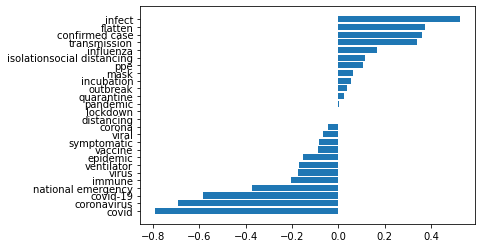

In [68]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = ['corona', 
                  'virus', 
                  'viral', 
                  'covid', 
                  'influenza', 
                  'pandemic', 
                  'epidemic', 
                  'quarantine', 
                  'lockdown',
                  'distancing', 
                  'national emergency', 
                  'flatten', 
                  'infect', 
                  'ventilator', 
                  'mask', 
                  'symptomatic', 
                  'immune', 
                  'incubation', 
                  'transmission', 
                  'vaccine',
                  'confirmed case',
                  'coronavirus',
                  'covid-19',
                  'outbreak',
                  'ppe',
                  'isolation'
                  'social distancing' ]
f_importances(anxiety_classifier.coef_.toarray()[0], features_names)

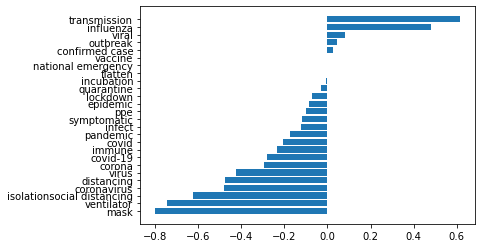

In [69]:
f_importances(depression_classifier.coef_.toarray()[0], features_names)

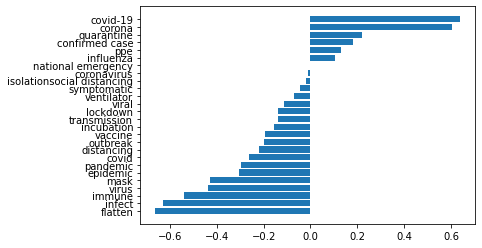

In [70]:
f_importances(mentalhealth_classifier.coef_.toarray()[0], features_names)

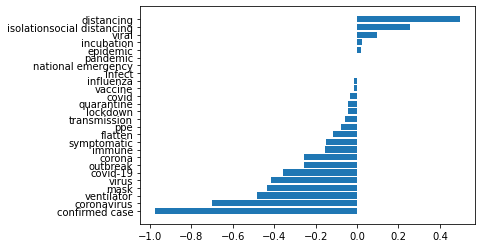

In [71]:
f_importances(suicidewatch_classifier.coef_.toarray()[0], features_names)

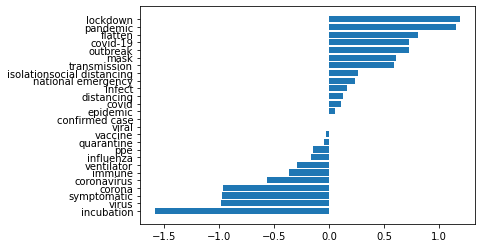

In [72]:
f_importances(covid19_support_classifier.coef_.toarray()[0], features_names)

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

60914


/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


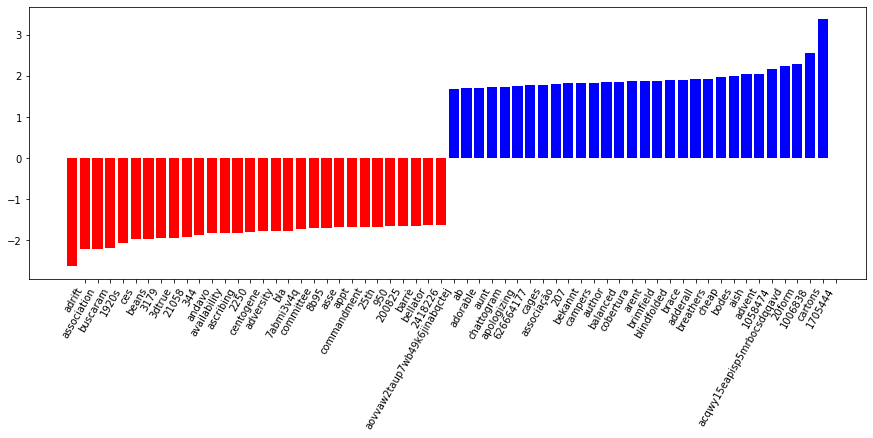

In [79]:
def plot_coefficients(classifier, feature_names, top_features=30):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    
cv = CountVectorizer(stop_words = 'english')
cv.fit(train_data.body.to_list())
print (len(cv.vocabulary_))

svm = LinearSVC()
svm.fit(x_train, y_train)

plot_coefficients(svm, cv.get_feature_names())